# Chinese Placement Test with Logistic Regression and Active Learning

An interesting problem with language learning apps is how to estimate the prior knowledge, the vocabulary, of a new user. Unless the user is a complete beginner, they will come with at least some level of prior knowledge in Chinese. Specifying exactly what you know is too much effort if you know tons of words.

Many content sites divide up content by HSK level (Hanyu Shuiping Kaoshi). For those unfamiliar with Chinese or the HSK, it's a set of standardized test where each level comes with a set of required words. For each level the number of new words roughly doubles (150, 150, 300, 600, 1300 and 2500).

Given the popularity of teaching to the test, the use of these levels in teaching material and apps is pretty ubiquitous. But dividing content based on HSK level is a pretty crude measure. What happens when you're between levels? Then you're bound to over or underestimate the number of words by quite a bit, especially for higher levels. It also doesn't say anything about the words outside the HSK. This is a problem for people like me, who don't follow the HSK very closely, but instead learn words as I come across them in various materials.

So for this little experiement, I'd like to be able to estimate the probability of a user knowing *any* word in the Chinese language, given a *much smaller* sample of the user's knowledge. Hopefully, the solution I'll present here could be applied to any kind of learning application where there are some properties of the atomic pieces of information that could be used to predict knowledge.

## What do we know about words?
In order to predict the word probabilities we need some features to base the prediction on. Two features pop out immediately: HSK level (duh...) and word frequency in the language. Roughly speaking, you'd expect higher HSK words to be lower frequency words, but as it turns out, the HSK levels aren't that clear cut. And even though the features are correlated, the HSK level carries additional information, since learners are very likely to use learning material that follow it.

Before analyzing word frequencies and HSK words, we need to load a dictionary, a list of word frequencies and HSK words. If you wish to read the code, just click "show code" below:

In [57]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import re
import time
import random
from datetime import datetime
from itertools import combinations
from collections import defaultdict
from textwrap import wrap

import jieba
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

#-----------------------------------------------------------------------
# Load the Cedict dictionary
#-----------------------------------------------------------------------
dictionary = defaultdict(list)
filter_out_patterns = [
    'see ',
    'abbr. for ',
    'see also ',
    'also written ',
    'euphemistic variant of',
    'variant of ',
    'unofficial variant of ',
    'archaic variant of ',
    'old variant of ',
    'ancient variant of ',
    'erhua variant of ',
    'Japanese variant of ',
    'CL:',
    '(old)',
    '(dialect)',
    '(surname)',
    '(Cantonese)',
    'radical',
    'Mandarin equivalent'
]

with open('cedict_ts.u8') as f:
    for i, line in enumerate(f):
        if line.startswith('#'): # Skip comments
            continue

        _, hz, py, transl = re.match(
            r"(\S*) (\S*) \[(.*)\] \/(.*)\/", line).groups()
        
        if py[0].isupper():
            continue # Skip named entities

        t_split = transl.split('/')
        t_filtered = []
        for t in t_split:
            if t.startswith('surname '):
                continue
            not_note_pattern = r'[\w\W]*\([\w\W]* pr\. [\w\W]*\)'
            if ' pr. ' in t and not re.match(not_note_pattern, t):
                # short for pronounciation. There's:
                # also pr. , Taiwain pr. , Japan pr.
                # However, when the pr. is inside parenthesis, it applies to
                # the translation which comes before
                continue

            filter_out = False
            for pattern in filter_out_patterns:
                if pattern in t:
                    filter_out = True
            if filter_out:
                continue
            t_filtered.append(t)
                    
        if len(t_filtered) > 0:
            dictionary[hz].append((py, t_filtered))

#-----------------------------------------------------------------------
# Load Weibo word frequencies
#-----------------------------------------------------------------------
word_freq = {}
word_freq_all = {}
with open('weibo_wordfreq.release_UTF-8.txt', encoding='utf-8-sig') as f: 
    for line in f.readlines():
        word, count = line.split('\t')
        if word in word_freq:
            continue

        word_freq_all[word] = int(count)
        if len(dictionary[word]) == 0:
            continue

        word_freq[word] = int(count)

words = list(word_freq.keys())
# Correct the frequency of components (component can not have lower frequency than compound)
for w in words:
    f = word_freq[w]
    if f < 50000: continue # skip uncommon words to speed up
    substrs = [w[x:y] for x, y in combinations(range(len(w)+1), r=2)]
    for substr in substrs:
        if substr not in words: continue
        subf = word_freq.get(substr, 0)
        if subf < f:
            word_freq[substr] = f
            
# Calculate word rank, higher for higher frequencies
word_rank = {w: r for r, (w, _) in 
             enumerate(sorted(word_freq.items(), key=lambda x: x[1]))}

#-----------------------------------------------------------------------
# Load the HSK word lists
#-----------------------------------------------------------------------
hsk_words_by_lvl = {}
hsk_lvl_by_word = {}
for lvl in range(1, 7):
    words = []
    with open(f'hsk/HSK{lvl}.txt', encoding='utf-8-sig') as f:
        lines = list(f.readlines())
        for w in lines:
            w = w.strip() # strip away newlines
            if w not in word_freq: continue # some HSK words are not in dict
            words.append((w, word_freq[w]))
            hsk_lvl_by_word[w] = lvl
    hsk_words_by_lvl[lvl] = words
    
#-----------------------------------------------------------------------
# Add components of HSK words as separate HSK words, e.g. 后面 -> 后， 面
# This is because the HSK lists are missing most of these components
#-----------------------------------------------------------------------
# First, build an index over all HSK words for all their substrings
hsk_word_index = {}
for lvl in range(1, 7):
    for w, f in hsk_words_by_lvl[lvl]:
        substrs = [w[x:y] for x, y in combinations(range(len(w)+1), r=2)]
        for substr in substrs:
            _, _, curr_lvl = hsk_word_index.get(substr, (None, None, 7))
            if lvl < curr_lvl:
                hsk_word_index[substr] = (w, f, lvl)

# Next, go through all non-HSK words and see if they are a component in an HSK word
# If so, add them to the corresponding HSK level (if also in dictionary)
component_assignments_per_lvl = defaultdict(list)
for w, f in word_freq.items():
    if w in hsk_lvl_by_word:
        continue # Already is HSK word

    if w in hsk_word_index:
        hsk_w, f, lvl = hsk_word_index[w]
        hsk_words_by_lvl[lvl].append((w, f))
        hsk_lvl_by_word[w] = lvl
        component_assignments_per_lvl[lvl].append((w, hsk_w))

# Some debug prints
if False:
    for lvl in range(1, 4):
        words = ' '.join([w for w, _ in component_assignments_per_lvl[lvl]])
        print(f'Component HSK {lvl} words:')
        print('\n'.join(wrap(words, 80)))

    print('\nAdded for each level: ')
    for lvl in range(1, 7):
        print(f'HSK{lvl}: {len(component_assignments_per_lvl[lvl])}')


   
We can now make a boxplot of the word frequencies of the different HSK levels. As you can see, higher levels tend to have lower frequency words, and also a much smaller range of frequencies. The smaller ranges makes sense, since there are many more ways a word can have high frequency (there is no upper bound), than they can have a low frequency. But ignoring this we can already see that there is significant overlap between the levels. 

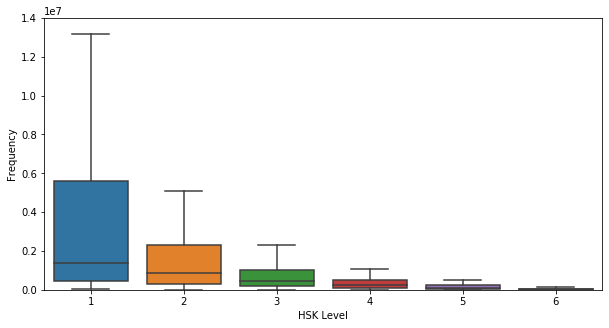

In [2]:
freqs = np.array([f for words in hsk_words_by_lvl.values()
                  for _, f in words])
lvls = np.array([lvl for lvl, words in hsk_words_by_lvl.items()
                 for w in words])
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=lvls, y=freqs, ax=ax, fliersize=0);
ax.set(ylim=(0, 1.4e7), xlabel='HSK Level', ylabel='Frequency');

Worth noting is that these word frequencies are based on a Weibo (Chinese Twitter) dataset. At first I used a corpus based on all kinds of sources like news, novels etc, but Weibo is more colloquial which I think is more representative of the type of language learners are interested in. Ideally, we'd prefer a dataset with text a learner is likely to encounter: course text books, tv-shows and movies, chat 

In order to visualize where HSK words end up as a function of frequency, here's a bar chart showing the most common 5000 words with the most frequent to the right. Each colored bar is a word in HSK and white gaps are words not in the HSK. It drives home the point that
1. There is no clear visual separation between levels
2. HSK really has plenty of gaps in this range

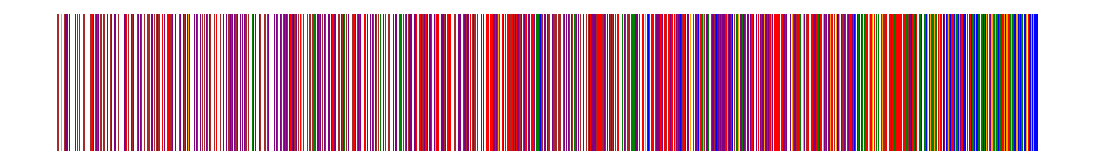

In [105]:
# Find the k most frequent words and their HSK level
K = 5000
common_k_words = sorted(list(word_freq.items()), key=lambda x: x[1])[-K:]
common_k_words_lvls = [(w, hsk_lvl_by_word.get(w, None)) for w, f in common_k_words]

color_map = {None: 'white', 1: 'blue', 2: 'orange', 3: 'green', 4: 'red', 5: 'purple', 6: 'brown'}
colors = [color_map[lvl] for _, lvl in common_k_words_lvls]
plt.figure(figsize=(15, 2))
ax = plt.axes([0,0,1,1], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.bar(np.arange(len(colors)), np.ones(len(colors)), width=1.0, color=colors)
plt.show()


It's also a good idea to have a look at the distribution of words over frequencies and see if we can learn anything from it.

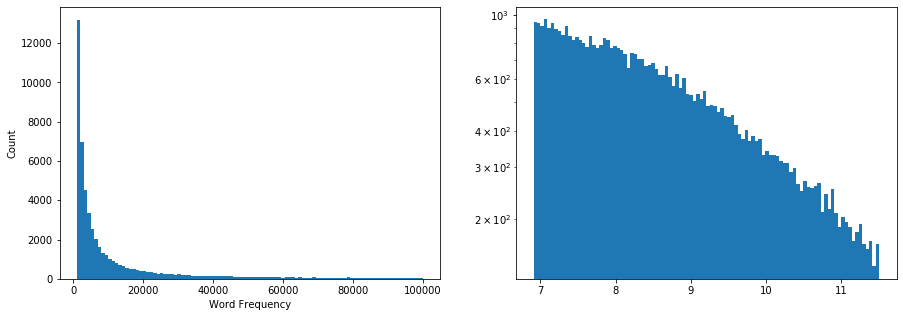

In [4]:
# Reverse order to lowest frequency first
counts = np.array(list(word_freq_all.values()))
counts_subrange = counts[(counts > 1000) & (counts < 100000)]
plt.rcParams['figure.figsize'] = [15, 5] # set larger plots
plt.subplot(1, 2, 1)
plt.hist(counts_subrange, 100)
plt.ylabel('Count')
plt.xlabel('Word Frequency')
plt.subplot(1, 2, 2)
plt.hist(np.log(counts_subrange), 100, log=True)

plt.show()

As it turns out, word frequencies in language corpora tend to follow [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), which is a discrete version of the Pareto distribution on word rank rather than frequency. The second graph, which is a log-log plot, seems to indicate this as well, since the graph of a Pareto distribution should look roughly linear when plotted this way. It's not quite as linear as I'd hoped, but good enough.

### Advanced modeling

If we want to build a really advanced model, we might want to take word covariances into account. For example, knowing "刀 - knife" makes knowing "叉 - fork" much more likley, because they tend to co-occur and be learned together. This would also include domains of co-occuring words, like "household and child-caring words" which is a domain I know disproportionately well after spending a month at home caring for my son together with my Chinese mother-in-law (who doesn't speak English, I might add).

In the end, I think adding co-occurances would have little ROI for the added complexity, although it might be a topic worth revisiting in the future. 

## Making a prediction

Now that we know our data a bit better we can think about how to predict a user's vocabulary. The idea is to create some kind of interactive procedure to iteratively discover this distribution. This way we can hone in on the user's skill level without asking tons of questions up front.

Still, "knowing" a word is a bit of a loose concept since being able to produce a translation given a Hanzi cue doesn't really show whether you can use it well in a sentence. Or being able to write it, or recognize it in speech etc. There are many ways you could imagine probing the user, but this little proof of concetp I'll simplify the problem to just a binary decision for Hanzi+Pinyin+Translation combos.

First, let's consider a single independent variable, frequency, and see what we can do. Predicting a probability based on a independent variable seems like a perfect job for *logistic regression*. It works by scaling the independent variable, adding some bias to it and then putting the result through the sigmoid function, producing a value between 0 and 1:

$$\frac{1}{1+e^{-(x^{L}_1 \beta_1 + \ldots + x^{L}_n \beta_n + \beta_c)}}$$

Logistic regression finds the best values for the \\(\beta\\) coefficients that minimize the *Cross Entropy Loss*. Since we are essentially training a separate predictor for each individual user with very few data points, it's a good idea to use a simple model like this, with as few variables as possible in order to avoid overfitting and make sampling easier.

Let's try it by picking some random words from different HSK levels, assigning positive labels to levels 1-3, and negative labels to levels 4-6 and see what it looks like. Due to the underlying Pareto distribution, it's better to use frequency rank rather than the frequency as the independent variable, so that we have a uniform discrete distribution over the words:

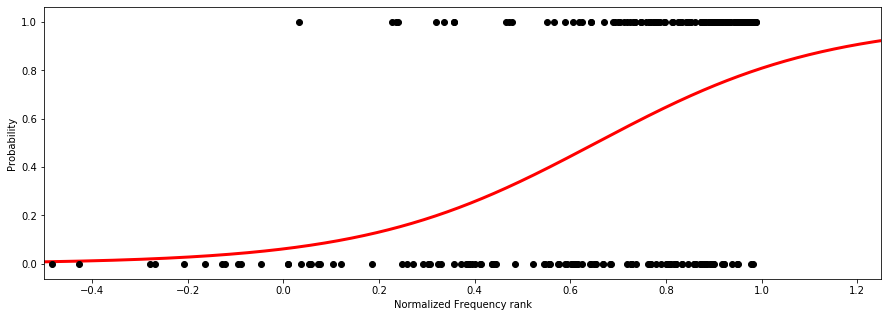

In [106]:
word_rank_list = sorted(list(word_rank.items()), key=lambda x: x[1])
words = [w for w, _ in word_rank_list]
ranks = np.arange(len(word_rank_list))
in_hsk = np.array([w in hsk_word_index for w in words])
hsk_lvls = np.array([hsk_lvl_by_word.get(w, 0) for w in words])

# -----------------------------------------------------------------------
# Here are a few different versions of the hsk variable
# NOTE: out of these options, quadratic has the lowest mean loss and std
# -----------------------------------------------------------------------
# Unused:
#hsk_data = []
# Quadratic:
hsk_data = [np.array([(7 - hsk_lvl_by_word.get(w, 7))**2/36 for w in words])]
# Linear:
#hsk_data = [np.array([(7 - hsk_lvl_by_word.get(w, 7))/6 for w in words])]
# Single binary:
#hsk_data = [np.array([1.0 if w in hsk_lvl_by_word else 0.0 for w in words])]
# Per level binary:
#hsk_data = [np.array([1.0 if hsk_lvl_by_word.get(w, None) == lvl else 0.0 for w in words])
#            for lvl in range(1, 7)]

data = np.vstack((ranks.astype(float), *hsk_data)).T
data_hsk_mean = data[in_hsk, 0].mean(axis=0)
data_hsk_std = data[in_hsk, 0].std(axis=0)
normalized_data = data.copy()
normalized_data[:, 0] = (data[:, 0] - data_hsk_mean) / data_hsk_std
normalized_word_rank = dict(zip(words, normalized_data[:, 0]))

def sample_HSK_words_per_lvl(K):
    test_words = []
    random.seed(1) # Make sure we randomize reproducibly
    for lvl in range(1, 7):
        test_words = test_words + random.sample(hsk_words_by_lvl[lvl], K)
    return test_words

K = 50
test_words = sample_HSK_words_per_lvl(K)
test_rank = np.array([normalized_word_rank[w] for w, _ in test_words]).reshape(-1, 1)
# Set the lower level words as known, rest as unknown
outcomes = np.zeros(len(test_words))
outcomes[:len(test_words) // 2] = 1

def plot_logistic_regression(X, y, lr, show=True):
    plt.figure()
    plt.scatter(X.ravel(), y, color='black', zorder=20)
    X_test = np.linspace(-0.5, 1.25, 1000)
    y_plot = lr.predict_proba(X_test.reshape(-1, 1))[:, 1]
    plt.plot(X_test, y_plot, color='red', linewidth=3)
    plt.ylabel('Probability')
    plt.xlabel('Normalized Frequency rank')
    plt.xlim(-0.5, 1.25)
    if show: plt.show()

lr = LogisticRegression(random_state=0, solver='lbfgs', C=1e9)
lr.fit(test_rank, outcomes)
plot_logistic_regression(test_rank, outcomes, lr)


## Active Learning
How much data would we need to make a good prediction, and which words would we pick? Let's pretend that we already have a previous "best guess" logistic regression fit. This best guess could be completely manual, based on the user's rough HSK level, or a fit on a small sample of data. Could we use this estimate to pick good words to inquire about?

My intuition tells me that words close to 0 or 1 probability are not good picks, since we're very sure about them. It would be better to pick words we're uncertain about, around 0.5. 

What we want is to find the word which would be the most surprising if we got it wrong, but is also likely to happen. More concretely, we want the *surprisal* for being wrong, times the probability of being wrong about it.

Suprisal is an actual term in information theory, although most often called "information content". The surprisal/information of an event happening is \\(I(X) = -\log(P(X))\\). This means that if the probability of X happening is 0, we're infinitely surprised if it does actually happen (since \\(-\log(0)=\infty\\)). If it's 1, then we're not surprised at all if it happens (since \\(-\log(1)=0\\)).

What we're looking for then is the *expected* surprisal of being wrong for both classes: 

$$ \sum_{c \in \{T, F\}} P(W=c)I(W=c) $$

This is the same as the *entropy* for the binary probability distribution for a word. As it turns out, the maximum of this function is X=0.5, following our intuition. It also maximizes the expected loss for the Cross Entropy loss function, which gives further validity to the idea. There are other ways to sample for active learning, e.g. sampling close to the decision boundary, but this one is one of the basic ones and it's what I came up with before knowing what to google for :)


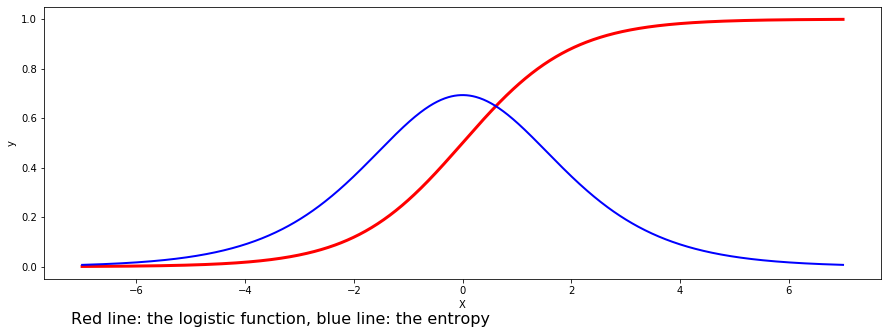

In [91]:
plt.figure()
X = np.linspace(-7.0, 7.0, 1000)
y = 1 / (1 + np.exp(-X))
E = - y * np.log(y) - (1 - y) * np.log(1-y)
plt.plot(X, y, color='red', linewidth=3)
plt.plot(X, E, color='blue', linewidth=2)
plt.ylabel('y')
plt.xlabel('X')
plt.figtext(.15, 0, "Red line: the logistic function, blue line: the entropy", fontsize=16)
plt.show()

Rather than just picking the highest entropy word, we can instead sample a bunch of words according to the entropy curve above, reflecting our underlying uncertainty.

This way then, we can iteratively sample a bunch of words to test using the best current logistic regression fit, until some stopping criteria.

This begs the question of how to sample words for the first iteration. It's important to get samples in both classes with varied inputs. For symmetry, we can set the coefficients of a logistic regression manually using a rough fluency/HSK level provided by the user. To determine the coefficients to use for the logistic function, we can use the constraints that we want the probability to be 0.5 at a point \\(x^{L}_{1}, ..., x^{L}_{n}\\) that represents the user's level. Then we can solve the intercept \\(\beta_c\\) given our best guess for the influence factors for each input variable \\(\beta_1, \ldots, \beta_n\\):
$$\frac{1}{1+e^{-(x^{L}_1 \beta_1 + \ldots + x^{L}_n \beta_n + \beta_c)}} = 0.5 \implies \beta_c = -(x^{L}_1 \beta_1 + \ldots + x^{L}_n \beta_n)$$

As for setting \\(x^{L}_{1}, ..., x^{L}_{n}\\), for frequency rank I found it best to set it to the upper quartile of the rank within the HSK level. For \\(\beta\\) I found it working best to increase it quadratically with the reverse HSK level, resulting in a narrower distribution for lower levels.

One practical detail for sampling from this distribution is that if done naively, we will get biased sampling due to there being probability mass *outside* the valid range of values. The result is that when we sample words, we will be biased towards sampling more difficult words. Here we can also see the reason for using rank rather than frequency: if we get even a little bit of probability assigned to the lower frequencies, we'll end up sampling a vast majority of words from there, due to the underlying Pareto distribution.

## HSK variable
At this point it's time to add in the HSK variable as a predictor. Instead of using a normalized HSK level, it makes more sense to reverse it such that HSK 1 becomes 6 and HSK 6 becomes 1, and "no level" becomes 0. After trying various
1. A binary indicator variable (HSK or not)
2. Binary indicators for each level
3. The reversed HSK level
4. The squared reversed HSK level

I found that the squared one worked best, probably related to the doubling of word count for consecutive levels.

# Procedure, Dataset and Result
The procedure so far is then:
1. Ask for user's rough fluency level
2. Set the initial logistic regression coefficients based on said level
3. Until convergence or maximum number of iterations:
    1. Sample N words based on word entropy
    2. Collect binary yes/no answers for those words
    3. Perform a logistic regression fit using all sampled and answered words so far

How do we make sure this procedure actually works? Well, I have one potential dataset: me. I have 3765 notes in my Anki (an open-source spaced repetition app), which I've exported to a csv. I also add to it the earlier HSK levels which I have completed but not added to Anki, as well as a list of other words which I know, for a total of 5671 words:


In [7]:
HANZI_UTF_RANGES = [
    ('\u4E00', '\u9FFF'),
    ('\u3400', '\u4DBF'),
    ('\uF900', '\uFAFF')
]

def is_hanzi(char):
    for start, end in HANZI_UTF_RANGES:
        if ord(char) >= ord(start) and ord(char) <= ord(end):
            return True
    return False

def filter_hanzi(text):
    return ''.join(char for char in text if is_hanzi(char))

anki_words = set()
with open('anki_notes.txt') as f:
    for line in f:
        hanzi = filter_hanzi(line)
        #print(line)
        for character in hanzi:
            if character in words:
                anki_words.add(character)
        for token, *_ in jieba.tokenize(hanzi, mode='search'):
            if token in words:
                anki_words.add(token)
        if len(dictionary[hanzi]) != 0:
            anki_words.add(token)
                
# Add words from HSK levels I learned before using Anki
for lvl in range(1, 5):
    for w, _ in hsk_words_by_lvl[lvl]:
        anki_words.add(w)
        
# Add manually gathered extra words
with open('known_words.txt') as f:
    for line in f:
        anki_words.add(line.strip())


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/0k/m1fk8jtx5pn1_13nstf4gg7r0000gn/T/jieba.cache
Loading model cost 0.973 seconds.
Prefix dict has been built succesfully.


With my vocabulary, I can run as many randomized simulations as I'd like by simply providing answers based on the vocabulary, and then checking the final result in terms of loss over the whole vocabulary and other useful metrics. Below is the code for the whole procedure if you'd like to check it out:

In [110]:
seed = datetime.now().microsecond
random.seed(seed)
print('Using seed:', seed)
np.seterr(all='raise')

component_words = set()
for lvl in range(1, 7):
    component_words.update(set(w for w, _ in component_assignments_per_lvl[lvl]))
    
def prevent_nans(probs):
    probs[probs[:, 0] == 0.0, 0] = 1-1e-20 # Prevent NaNs
    probs[probs[:, 1] == 1.0, 1] = 1e-20

def lr_prediction_and_sampling_cdf(lr, plot=False):
    probs = lr.predict_proba(normalized_data)
    low_prob = probs[:, 1] < 0.01
    prevent_nans(probs)
    try:
        expected_information = -probs*np.log(probs)
    except:
        breakpoint()
    expected_information = expected_information.sum(axis=1)
    lr_probs = expected_information / expected_information.sum()
    # Clip the long tail, to compensate for bias (very low probability words)
    #lr_probs[low_prob] = 0
    lr_cdf = np.cumsum(lr_probs)
    if plot:
        plt.plot(normalized_data[::100, 0], lr_probs[::100])
        plt.show()
    return probs, lr_cdf
    

def run_iterative_lr(include_hsk_lvl=False, plot_lr=False, num_samples=20,
                     term_absdiff_thres=None, term_max_iter=5, answer_based_on_anki=True, anki_lvl=0):
    # Ask for HSK level
    user_hsk_lvl = anki_lvl
    while user_hsk_lvl == 0:
        print("HSK1: Beginner 1")
        print("HSK2: Beginner 2")
        print("HSK3: Intermediate 1")
        print("HSK4: Intermediate 2")
        print("HSK5: Advanced 1")
        print("HSK6: Advanced 2")

        answer = input('What is roughly your HSK level, 1-6? ')
        fail = False
        try:
            user_hsk_lvl = int(answer)
        except:
            fail = True
        if not (1 <= user_hsk_lvl <= 6):
            fail = True
        if fail:
            print('Please choose a number between 1-6\n')

    sampled_words = set()
    sampled_outcomes = []
    sampled_indices = []
    lr_cdf = None
    stats_history = []
    iteration = 0

    # Set a sampling distribution based on the user's specified HSK level
    # Found that cubing the reverse of the hsk level is a good initial frequency rank coefficient
    # Small levels lead to big coefficients, which lead to a narrower sampling distribution
    # Add a little to the lower levels to make sure low frequency words don't dominate
    initial_sampling_freq_coef = (7 - user_hsk_lvl)**3 + (0.2 if user_hsk_lvl <= 2 else 0.0)
    initial_sampling_intercept = -np.quantile(normalized_data[hsk_lvls == user_hsk_lvl, 0], .75) * initial_sampling_freq_coef

    lr = LogisticRegression()
    lr.coef_ = np.array([initial_sampling_freq_coef, *np.zeros(normalized_data.shape[1]-1)]).reshape(1, -1)
    lr.intercept_ = initial_sampling_intercept
    _, lr_cdf = lr_prediction_and_sampling_cdf(lr)
    lr_coeffs, prev_lr_coeffs = None, None
    def terminate():
        if term_max_iter is not None and iteration >= term_max_iter:
            return True
        if term_absdiff_thres is None or prev_lr_coeffs is None:
            return False
        sum_absdiff = np.abs(lr_coeffs - prev_lr_coeffs).sum()
        return sum_absdiff < term_absdiff_thres

    
    while not terminate():
        if not answer_based_on_anki: print(f'Iteration {iteration+1}')

        curr_sample = []
        while len(curr_sample) < num_samples:
            r = random.random()
            idx = np.searchsorted(lr_cdf, r)
            idx = idx -1 if idx == len(lr_cdf) else idx
            try:
                w = words[idx]
            except:
                breakpoint()
            if (idx in curr_sample or
                    w in sampled_words or
                    w in component_words):
                continue
            curr_sample.append(idx)

        outcomes = []
        sample_words = []
        sample_indices = []
        for idx in curr_sample:
            w, f = words[idx], normalized_data[idx, 0]
            hsk_lvl = hsk_lvl_by_word.get(w, None)

            # Fix race condition in streams resulting in input coming first
            if answer_based_on_anki:
                outcome = 1.0 if w in anki_words else 0.0
            else:
                print(f'HSK {hsk_lvl}: {w} {f}')
                for py, transls in dictionary[w]:
                    print(f'{py}: {"/".join(transls)}')

                time.sleep(0.05)
                answer = input('Do you know it, y/n? ')
                print('') # Give space to the next question
                outcome = 1.0 if answer == 'y' else 0.0

            sampled_words.add(w)
            outcomes.append(outcome)

        sampled_indices = sampled_indices + curr_sample
        sampled_outcomes = sampled_outcomes + outcomes

        if len(np.unique(np.array(sampled_outcomes))) != 2:
            # Need data from both true/false classes before doing regression
            iteration += 1
            continue

        # NOTE: have to set a higher C in order to reduce regularization
        # see https://stackoverflow.com/a/52064154
        # By default C=1.0 which produces very high regularization
        # But we still need some regularization, especially when an HSK1-3 student
        # don't know any words outside HSK, this will make the estimate for rank coefficient
        # too extreme
        lr = LogisticRegression(random_state=0, solver='lbfgs', C=1e2)
        X = normalized_data[np.array(sampled_indices)]
        y = np.array(sampled_outcomes)
        lr.fit(X, y)
        
        prev_lr_coeffs, lr_coeffs = lr_coeffs, np.append(lr.coef_.ravel(), lr.intercept_)
        probs, lr_cdf = lr_prediction_and_sampling_cdf(lr)

        # Evaluate Cross Entropy Loss on words in Anki
        anki_mask = np.array([w in anki_words for w in words])
        anki_loss = -np.log(probs[anki_mask, 1]).sum()
        not_anki_loss = -np.log(probs[~anki_mask, 0]).sum()
        loss = anki_loss + not_anki_loss
        stats = {'anki_loss': anki_loss, 'not_anki_loss': not_anki_loss, 'loss': loss,
                 'outcomes': np.array(outcomes).sum() / len(outcomes), 'coeffs': lr_coeffs}
        for hsk in [True, False]:
            hsk_mask = in_hsk if hsk else ~in_hsk
            pos_outcomes = probs[:, 1] > 0.5
            neg_outcomes = probs[:, 1] < 0.5
            false_negatives = anki_mask & hsk_mask & neg_outcomes
            false_positives = ~anki_mask & hsk_mask & pos_outcomes
            true_negatives = ~anki_mask & hsk_mask & neg_outcomes
            true_positives = anki_mask & hsk_mask & pos_outcomes
            prefix = "hsk_" if hsk else "not_hsk_"
            stats[prefix+'FN'] = np.count_nonzero(false_negatives)
            stats[prefix+'FP'] = np.count_nonzero(false_positives)
            stats[prefix+'TN'] = np.count_nonzero(true_negatives)
            stats[prefix+'TP'] = np.count_nonzero(true_positives)

        stats_history.append(stats)
        iteration += 1
    return stats_history

NUM_ITER = 10
NUM_RUNS = 100

#run_iterative_lr(include_hsk_lvl=True, plot_lr=False, term_max_iter=NUM_ITER,
#                 answer_based_on_anki=False, anki_lvl=2)

loss = []
iteration = []
outcomes = []
final_losses = []
for i in range(NUM_RUNS):
    print('Run ', i)
    stats_history = run_iterative_lr(include_hsk_lvl=True, plot_lr=False, term_max_iter=NUM_ITER,
                                     answer_based_on_anki=True, anki_lvl=5)
    for i, stats in enumerate(stats_history):
        loss.append(stats['loss'])
        outcomes.append(stats['outcomes'])
        iteration.append(i)
    final_losses.append(stats_history[-1]['loss'])
final_losses = np.array(final_losses)
print('Mean final loss:', final_losses.mean(), ' std', final_losses.std())
print('Done')

Using seed: 49582
Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19
Run  20
Run  21
Run  22
Run  23
Run  24
Run  25
Run  26
Run  27
Run  28
Run  29
Run  30
Run  31
Run  32
Run  33
Run  34
Run  35
Run  36
Run  37
Run  38
Run  39
Run  40
Run  41
Run  42
Run  43
Run  44
Run  45
Run  46
Run  47
Run  48
Run  49
Run  50
Run  51
Run  52
Run  53
Run  54
Run  55
Run  56
Run  57
Run  58
Run  59
Run  60
Run  61
Run  62
Run  63
Run  64
Run  65
Run  66
Run  67
Run  68
Run  69
Run  70
Run  71
Run  72
Run  73
Run  74
Run  75
Run  76
Run  77
Run  78
Run  79
Run  80
Run  81
Run  82
Run  83
Run  84
Run  85
Run  86
Run  87
Run  88
Run  89
Run  90
Run  91
Run  92
Run  93
Run  94
Run  95
Run  96
Run  97
Run  98
Run  99
Mean final loss: 9483.898648983522  std 994.3789515103733
Done


Here are two key graphs:
1. The average loss over time for 100 randomized simulation runs. We naturally expect this loss to go down over time.
2. The percent of words that are answered correctly each iteration. We expect this to be around 0.5 if the fit is good. Due to previously mentioned sampling bias, the actual average is lower than that. After trying to correct for this, it's clear that there is still some difference of about 10% that I cannot account for.

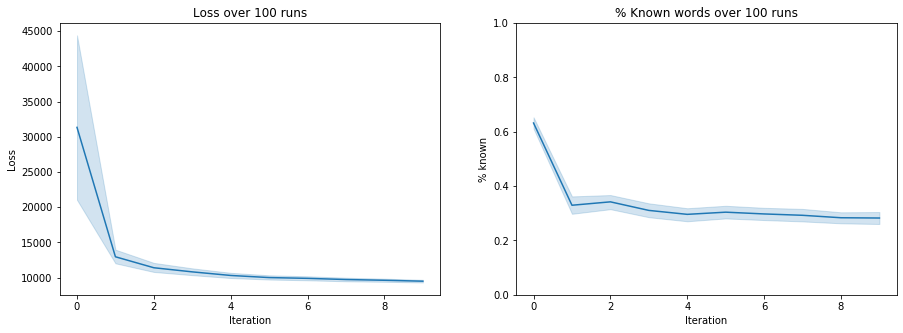

In [111]:
fig, axes = plt.subplots(1, 2)

sns.lineplot(x=np.array(iteration), y=np.array(loss), ax=axes[0]);
axes[0].set(xlabel='Iteration', ylabel='Loss', title=f'Loss over {NUM_RUNS} runs');
sns.lineplot(x=np.array(iteration), y=np.array(outcomes), ax=axes[1]);
axes[1].set(ylim=(0, 1), xlabel='Iteration', ylabel='% known', title=f'% Known words over {NUM_RUNS} runs');
plt.show()

## False Positives and False Negatives
A useful statistic for figuring out how well this system is actually doing is false positives and false negatives. We can use the predicted probabilities and threshold on > 0.5 to get a binary classification for each word. Here you can see the outcomes for the words in my dataset:

In [82]:
from IPython.display import HTML, display
import tabulate

h = random.choice(stats_history)
accuracy = []
precision = []
recall = []
for hsk in [True, False]:
    pre = 'hsk_' if hsk else 'not_hsk_'
    FN = h[pre+'FN']
    FP = h[pre+'FP']
    TP = h[pre+'TP']
    TN = h[pre+'TN']
    table = [["HSK" if hsk else "Non-HSK", "Negatives","Positives"],
             ["False", FN, FP],
             ["True", TN, TP]]
    display(HTML(tabulate.tabulate(table, headers="firstrow", tablefmt='html')))
    accuracy.append((TP+TN)/(TP+TN+FP+FN))
    precision.append(float('nan') if TP+FP == 0 else TP/(TP+FP))
    recall.append(TP/(TP+FN))
    
table = [["HSK","Non-HSK"],
         ["Accuracy", accuracy[0], accuracy[1]],
         ["Precision", precision[0], precision[1]],
         ["Recall", recall[0], recall[1]]]
display(HTML(tabulate.tabulate(table, headers="firstrow", tablefmt='html')))


HSK,Negatives,Positives
False,828,436
True,2924,2813


Non-HSK,Negatives,Positives
False,1637,40
True,46454,169


,HSK,Non-HSK
Accuracy,0.819454,0.96528
Precision,0.865805,0.808612
Recall,0.77259,0.093577


As we can see for the Non-HSK table, *most* non-HSK words in my vocabulary are misclassified as "don't know" (low recall) even though precision is fairly high. This shows how tough it is to predict vocabulary outside the HSK using only frequency. 

# Conclusion
Hopefully I've show that we can build a placement test that would shorted the on-boarding time in learning apps. Whether it generalizes well outside my own vocabulary is left to be seen. If you're reading this and is willing to donate your Anki notes, I'd happily accept them so that I can run more experiements!

While I've specifically applied it to Chinese, the general structure could be applied to any topic where there is some indication of frequency, difficulty or general order of study. For Chinese, we could imagine splitting reading, writing, listening and (speech) synthesis into different placement tests since learners often place different emphasis on them.


If you have any ideas or comments, please use the comment section below.